In [32]:
import glob
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats
from matplotlib.ticker import PercentFormatter

plt.style.use(["science", "nature"])
import pickle

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6
plt.rcParams['hatch.linewidth'] = 0.5

%matplotlib widget

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
    "annotation": "Annotated PAS",
    "Annotation": "Annotated PAS",
    "anno": "Annotated PAS",
}
type_map = {
    "Visium": "Spatial transcriptome",
    "VisiumHD": "Spatial transcriptome",
    "Chromium": "scRNA-seq",
    "Dropseq": "scRNA-seq",
    "Stereoseq": "Spatial transcriptome",
    "Slideseq": "Spatial transcriptome",
    "SpatialTranscriptomics": "Spatial transcriptome",
    "Microwell": "scRNA-seq",
}
order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
# order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium", "10X Visium HD","Stereo-seq", "Slide-seq V2", "Spatial Transcriptomics"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
palette=sns.color_palette(color, 7)
mm = 1/25.4

In [2]:
from pybedtools import BedTool
cs_path = "/root/apabenchmark/data/raw_bam_feature/filtered_cs"
cs_bed_list = glob.glob(f"{cs_path}/*.bed")
cs_count = []
for cs_bed in cs_bed_list:
    sample = os.path.basename(cs_bed).split(".")[0]
    sample_id = "_".join(os.path.basename(sample).split("_")[0:4])
    protocol = os.path.basename(sample).split("_")[0]
    cs_read_num = os.path.basename(sample).split("_")[4]
    match_type = os.path.basename(sample).split("_")[5]
    if match_type == "cs":
        continue
    else:
        utr_type = os.path.basename(sample).split("_")[6]

    counts = BedTool(cs_bed).count()
    cs_count.append({
        "sample": sample_id,
        "cs_read_num": cs_read_num,
        "match_type": match_type,
        "utr_type": utr_type,
        "counts": counts,
        "protocol": protocol
    })


In [3]:
cs_count_df = pd.DataFrame(cs_count)
cs_count_df["prop"] = cs_count_df["counts"] / cs_count_df.groupby(["cs_read_num","sample", "utr_type"])["counts"].transform("sum")
cs_count_df["protocol"] = cs_count_df["protocol"].map(protocol_map)
cs_count_df["cs_total"] = cs_count_df.groupby(["sample"])["counts"].transform("sum")

In [4]:
iodt_counts_list = glob.glob("/root/apabenchmark/data/raw_bam_feature/iodt/*.counts")
with open('/root/apabenchmark/data/raw_bam_feature/read_length/sample.yaml', 'r') as file:
    read_length_dict = yaml.safe_load(file)

raw_data_feature_dict = {}
for i, ic in enumerate(iodt_counts_list):
    iodt_count = int(open(ic).readlines()[0].strip())
    read_count = int(open(ic).readlines()[-1].strip())
    sample = ic.split("/")[-1].split(".")[0]
    protocol = ic.split("/")[-1].split("_")[0]
    raw_data_feature_dict[sample] = {
            "protocol": protocol_map[protocol],
            "iodt_count": iodt_count,
            "read_count": read_count,
            "type": type_map[protocol],
    }
read_count_df = pd.DataFrame(raw_data_feature_dict).T.reset_index(names="sample").loc[:,["sample","protocol", "read_count"]]
read_length_df = pd.DataFrame(read_length_dict["raw_sample"]).T.reset_index(names="sample")

In [5]:
cs_count_by_sample_df = pd.DataFrame(cs_count_df.groupby(["sample","protocol","utr_type","cs_read_num"])["counts"].sum()).reset_index().merge(read_count_df, on=["sample","protocol"]).merge(read_length_df, on=["sample"])
cs_count_by_sample_df["counts"] = cs_count_by_sample_df["counts"].astype(np.float64)
cs_count_by_sample_df["read_count"] = cs_count_by_sample_df["read_count"].astype(np.float64)
cs_count_by_sample_df["cs_by_read_counts"] = (cs_count_by_sample_df["counts"]) / cs_count_by_sample_df["read_count"]

# cs_count_by_sample_sum_df = pd.DataFrame(cs_count_df.groupby(["sample","protocol","cs_read_num"])["counts"].sum()).reset_index().merge(read_count_df, on=["sample","protocol"]).merge(read_length_df, on=["sample"])
# cs_count_by_sample_sum_df["counts"] = cs_count_by_sample_sum_df["counts"].astype(np.float64)
# cs_count_by_sample_sum_df["read_count"] = cs_count_by_sample_sum_df["read_count"].astype(np.float64)
# cs_count_by_sample_sum_df["cs_by_read_counts"] = (cs_count_by_sample_sum_df["counts"]) / cs_count_by_sample_sum_df["read_count"]

In [37]:
cs_count_by_sample_df.to_csv("/root/apabenchmark/data/raw_bam_feature/cs_count_by_sample.csv", index=False)
cs_count_df.to_csv("/root/apabenchmark/data/raw_bam_feature/cs_count.csv", index=False)

/tmp/ipykernel_1644659/2798166218.py:71: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_1644659/2798166218.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=6)


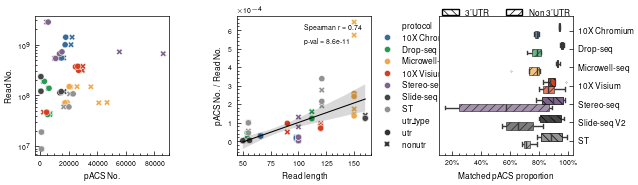

In [34]:
plt.close()
fig, (ax1,ax2, ax3)= plt.subplots(1,3, figsize=(165*mm,50*mm))

sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="counts",
    y="read_count",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax1,
    legend=False,
    s=20
)
# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("pACS No.")
ax1.set_ylabel("Read No.")


sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax2,
    s=20
)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel("Read length")
ax2.set_ylabel("Efficiency")

sns.regplot(
    data = cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    scatter=False,
    ax=ax2,
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
r2 = r_value**2
spearmanr, pval = stats.spearmanr(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
ax2.annotate(f"Spearman r = {spearmanr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
ax2.annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_xlabel("Read length")
ax2.set_ylabel("pACS No. / Read No.")
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

hatch_styles = ["\\\\\\\\", "////"]
colors = palette
alpha_values = [1, 0.7]

sns.boxplot(
    data=cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi")],
    x="prop",
    y="protocol",
    hue="utr_type",
    hue_order=["utr", "nonutr"],
    order=order,
    ax=ax3,
    legend=False,
    palette=palette,
    flierprops={"markersize":0.2},
    width=0.8,)

for j, bar in enumerate(ax3.patches):
    hatch_index = j // (len(ax3.patches) // len(hatch_styles))
    bar.set_hatch(hatch_styles[hatch_index])
    bar.set_alpha(alpha_values[hatch_index])
    bar.set_facecolor(colors[j % (len(ax3.patches) // len(hatch_styles))])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax3.set_xlabel("Matched pACS proportion")
ax3.set_ylabel("")
# move y-axis to the right
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=6)
ax3.tick_params(which="minor", right=False)
ax3.margins(y=0.06)
handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', hatch=hatch_style) for i, hatch_style in enumerate(hatch_styles)]
labels = ["3'UTR", "Non 3'UTR"]
ax3.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.savefig("/root/apabenchmark/plot/fig3/fig3ab.pdf", bbox_inches='tight', dpi=300)

In [68]:
for protocol in cs_count_df["protocol"].unique():
    utr_prop = cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi") & (cs_count_df["protocol"] == protocol) & (cs_count_df["utr_type"] == "utr")].sort_values("sample")["prop"].values
    nonutr_prop = cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi") & (cs_count_df["protocol"] == protocol) & (cs_count_df["utr_type"] == "nonutr")].sort_values("sample")["prop"].values
    print(f"{protocol} {stats.ranksums(utr_prop,nonutr_prop, alternative='greater')}")

Drop-seq RanksumsResult(statistic=2.3094010767585034, pvalue=0.010460667668897007)
10X Chromium RanksumsResult(statistic=2.3094010767585034, pvalue=0.010460667668897007)
Microwell-seq RanksumsResult(statistic=2.3094010767585034, pvalue=0.010460667668897007)
Slide-seq V2 RanksumsResult(statistic=1.7320508075688774, pvalue=0.0416322583317752)
Stereo-seq RanksumsResult(statistic=1.1547005383792517, pvalue=0.12410653949496181)
ST RanksumsResult(statistic=2.0207259421636903, pvalue=0.021654071405395978)
10X Visium RanksumsResult(statistic=0.5773502691896258, pvalue=0.28185143082538655)


In [53]:
cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi") & (cs_count_df["protocol"] == protocol) & (cs_count_df["utr_type"] == "utr")].sort_values("sample")

,sample,cs_read_num,match_type,utr_type,counts,protocol,prop,cs_total
172,Visium_mouse_brain_V19L01-041-C1,multi,match,utr,22101,10X Visium,0.823067,91910
180,Visium_mouse_brain_V19L29-035-D1,multi,match,utr,21478,10X Visium,0.868711,75645
209,Visium_mouse_kidney_V19L29-096-B1,multi,match,utr,23189,10X Visium,0.880539,78912
217,Visium_mouse_olfactorybulb_V10N30-322-A1,multi,match,utr,4439,10X Visium,0.986883,9153


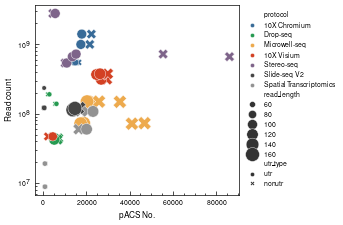

In [288]:


# fig, ax1= plt.subplots(1,1, figsize=(90*mm,60*mm))

# sns.scatterplot(
#     data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
#     x="counts",
#     y="read_count",
#     hue="protocol",
#     style="utr_type",
#     hue_order=order,
#     style_order=["utr","nonutr"],
#     palette=palette,
#     ax=ax1,
#     size="read_length",
#     sizes = (10, 100)
# )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# # ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlabel("pACS No.")
# ax1.set_ylabel("Read count")

# # sns.scatterplot(
# #     data=cs_count_by_sample_df,
# #     x="cs_by_read_counts",
# #     y="read_length",
# #     hue="protocol",
# #     style="utr_type",
# #     hue_order=order,
# #     style_order=["utr","nonutr"],
# #     palette=palette,
# #     ax=ax2,
# #     s=30,
# # )
# # ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# # ax2.set_xscale('log')
# # # ax2.yscale('log')
# # ax2.set_xlabel("pACS No. / Read count")
# # ax2.set_ylabel("Read length")

# plt.tight_layout()
# plt.savefig("/root/apabenchmark/plot/fig3/cs_counts_read_counts.pdf", dpi=300, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


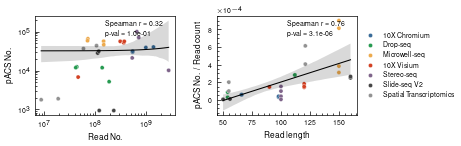

In [493]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(120*mm,40*mm))

sns.scatterplot(
    data=cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"],
    x="read_count",
    y="counts",
    hue="protocol",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax1,
    legend=False,
)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Read length")
ax1.set_ylabel("Efficiency")

sns.regplot(
    data = cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"],
    x="read_count",
    y="counts",
    scatter=False,
    ax=ax1,
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["read_count"],
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["counts"]
    )
r2 = r_value**2
spearmanr, pval = stats.spearmanr(
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["read_count"],
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["counts"]
    )
ax1.annotate(f"Spearman r = {spearmanr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
ax1.annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax1.set_xlabel("Read No.")
ax1.set_ylabel("pACS No.")
# ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')


sns.scatterplot(
    data=cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    hue="protocol",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax2,
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel("Read length")
ax2.set_ylabel("Efficiency")

sns.regplot(
    data = cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    scatter=False,
    ax=ax2,
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
r2 = r_value**2
spearmanr, pval = stats.spearmanr(
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_sum_df[cs_count_by_sample_sum_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
ax2.annotate(f"Spearman r = {spearmanr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
ax2.annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_xlabel("Read length")
ax2.set_ylabel("pACS No. / Read count")
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')



plt.tight_layout()
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.set_ylabel("")
# ax1.set_yticklabels([])

/tmp/ipykernel_302495/3280681445.py:13: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(


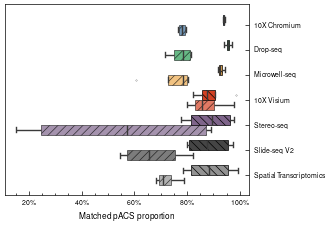

In [347]:
from matplotlib.ticker import PercentFormatter
hatch_styles = ["\\\\\\\\", "////"]

plt.close()
fig, ax1 = plt.subplots(
    1, 1, figsize=(60*mm,50*mm),
)
colors = palette
alpha_values = [1, 0.7]



sns.boxplot(
    data=cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi")],
    x="prop",
    y="protocol",
    hue="utr_type",
    hue_order=["utr", "nonutr"],
    order=order,
    ax=ax1,
    legend=False,
    palette=palette,
    flierprops={"markersize":0.2},
    width=0.8,)

for j, bar in enumerate(ax1.patches):
    hatch_index = j // (len(ax1.patches) // len(hatch_styles))
    bar.set_hatch(hatch_styles[hatch_index])
    bar.set_alpha(alpha_values[hatch_index])
    bar.set_facecolor(colors[j % (len(ax1.patches) // len(hatch_styles))])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.set_xlabel("Matched pACS proportion")
ax1.set_ylabel("")
# move y-axis to the right
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(which="minor", right=False)

# for ax in (ax2, ax3):
#     ax.set_ylabel("")
#     ax.set_yticklabels([])
#     ax.tick_params(which="minor", left=False)
    # ax2.set_ylabel("")
# ax2.set_yticklabels([])
# ax2.tick_params(which="minor", left=False)
ax1.margins(y=0.06)
ymin, ymax = ax1.get_ylim()
for ax in (ax1, ax2, ax3):
    ax.set_ylim([ymin, ymax])
# for ax in (ax1, ax2):
#     ax.margins(x=0.07,y=0.06)
# handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', hatch=hatch_style) for i, hatch_style in enumerate(hatch_styles)]
# labels = ["3'UTR pACS", "Non 3'UTR pACS"]
# plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig("/root/apabenchmark/plot/fig3/cs_prop.pdf", dpi=300, bbox_inches='tight')

In [349]:
phastcons_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/phastcons/phastcons.csv")

# phastcons_annotation_median = phastcons_df[phastcons_df["protocol"].isin(["annotation", "Annotation"])]["cons"].median()
# phastcons_annotation_upper = phastcons_df[phastcons_df["protocol"].isin(["annotation", "Annotation"])]["cons"].quantile(0.75)
# phastcons_annotation_lower = phastcons_df[phastcons_df["protocol"].isin(["annotation", "Annotation"])]["cons"].quantile(0.25)



phastcons_df["protocol"] = phastcons_df["protocol"].map(protocol_map)
phastcons_df["protocol"] = pd.Categorical(phastcons_df["protocol"], categories=order+["Annotated PAS"], ordered=True)
phastcons_df = phastcons_df.sort_values(["protocol", "type"], ascending=False)


phastcons_test_list = []
cons_sample2 = phastcons_df[(phastcons_df["protocol"].isin(["annotation", "Annotation"]))]["cons"]
for match_type in ["match", "unmatch"]:
    for utr_type in ["utr", "nonutr"]:
        for protocol in order:
            cons_sample1 = phastcons_df[(phastcons_df["protocol"] == protocol) & (phastcons_df["match_type"] == match_type) & (phastcons_df["utr_type"] == utr_type) & (phastcons_df["cs_read_num"] == "multi")]["cons"]
            cons_sample2 = phastcons_df[(phastcons_df["protocol"] == "Annotated PAS") & (phastcons_df["match_type"] == match_type) & (phastcons_df["utr_type"] == utr_type) & (phastcons_df["cs_read_num"] == "multi")]["cons"]
            t_cons, p_cons = stats.mannwhitneyu(cons_sample1, cons_sample2, alternative="less")
            phastcons_test_list.append({
                "protocol": protocol,
                "match_type": match_type,
                "utr_type": utr_type,
                "p": p_cons,
            })

/tmp/ipykernel_302495/3126058097.py:11: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(


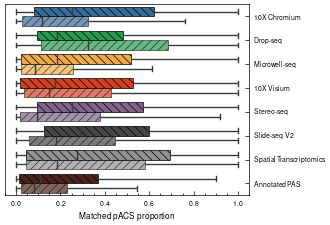

In [370]:
from matplotlib.ticker import PercentFormatter
hatch_styles = ["\\\\\\\\", "////"]

plt.close()
fig, ax1 = plt.subplots(
    1, 1, figsize=(80*mm,63*mm),
)
colors = palette + ["#4c221b"]
alpha_values = [1, 0.7]

sns.boxplot(
    data=phastcons_df[(phastcons_df["match_type"] == "unmatch") & (phastcons_df["cs_read_num"] == "multi")],
    x="cons",
    y="protocol",
    hue="utr_type",
    hue_order=["utr", "nonutr"],
    order=order+["Annotated PAS"],
    ax=ax1,
    legend=False,
    palette=palette,
    showfliers=False,
    width=0.8,)

for j, bar in enumerate(ax1.patches):
    hatch_index = j // (len(ax1.patches) // len(hatch_styles))
    bar.set_hatch(hatch_styles[hatch_index])
    bar.set_alpha(alpha_values[hatch_index])
    bar.set_facecolor(colors[j % (len(ax1.patches) // len(hatch_styles))])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.set_xlabel("Matched pACS proportion")
ax1.set_ylabel("")
# move y-axis to the right
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.tick_params(which="minor", right=False)


In [400]:
# cs type
cs_motif_unmatch_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_unmatch.csv"
cs_motif_unmatch_df = pd.read_csv(cs_motif_unmatch_cat)
cs_motif_unmatch_df = cs_motif_unmatch_df.groupby(["protocol", "category","type","match_type","cs_read_num","utr_type"])["count"].sum().reset_index()
cs_motif_unmatch_df["prop"] = cs_motif_unmatch_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)
cs_motif_unmatch_df["protocol"] = pd.Categorical(cs_motif_unmatch_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_unmatch_df = cs_motif_unmatch_df.sort_values("protocol")
# cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)

cs_motif_match_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_match.csv"
cs_motif_match_df = pd.read_csv(cs_motif_match_cat)
cs_motif_match_df = cs_motif_match_df.groupby(["protocol", "category","type","match_type","cs_read_num","utr_type"])["count"].sum().reset_index()
cs_motif_match_df["prop"] = cs_motif_match_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_match_df["protocol"] = cs_motif_match_df["protocol"].map(protocol_map)
cs_motif_match_df["protocol"] = pd.Categorical(cs_motif_match_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_match_df = cs_motif_match_df.sort_values("protocol")
cs_motif_df = pd.concat([cs_motif_unmatch_df, cs_motif_match_df])


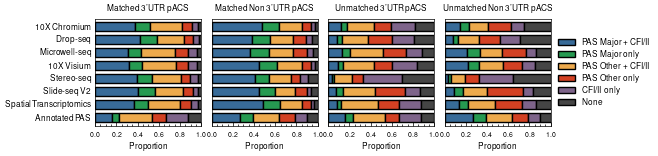

In [401]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

plt.close()
fig = plt.figure(figsize=(170*mm, 42*mm))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

bar_width = 0.7
protocol_padding = 0.2
protocols = cs_motif_df['protocol'].unique()
types = ["multi_match_utr", "multi_match_nonutr", "multi_unmatch_utr", "multi_unmatch_nonutr"]
title = ["Matched 3'UTR pACS", "Matched Non 3'UTR pACS", "Unmatched 3'UTR pACS", "Unmatched Non 3'UTR pACS"]
motif_categorys = [
    "PAS Major + CFI/II",
    "PAS Major only",
    "PAS Other + CFI/II",
    "PAS Other only",
    "CFI/II only",
    "None"
]

for i, type_ in enumerate(types):
    ax = plt.subplot(gs[i])
    y = np.arange(len(protocols))
    left = np.zeros(len(protocols))
    for j, motif_category in enumerate(motif_categorys):
        data = cs_motif_df[(cs_motif_df["category"] == motif_category) & (cs_motif_df["type"] == type_)]["prop"].values
        if data.shape[0] == 0:
            continue
        ax.barh(y, data, bar_width, left=left, label=motif_category, color=palette[j], edgecolor='black')
        left += data

    ax.set_xlim([0, 1])
    
    ax.set_ylim([-0.5, len(protocols) - 0.5])
    ax.tick_params(which='both', left=False)
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    ax.set_yticks(y)
    ax.set_yticklabels(protocols, fontsize=6)
    ax.set_title(title[i], fontsize=6)
    ax.set_ylim([y[0] - bar_width/2 - protocol_padding, y[-1] + bar_width])
    if i != 0:
        ax.tick_params(labelleft=False)
    ax.invert_yaxis()

motif_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=1) for color in palette]
motif_labels = motif_categorys
motif_legend = plt.legend(motif_handles, motif_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6, )

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, bottom=0.2)
plt.savefig("/root/apabenchmark/plot/fig3/cs_motif.pdf", dpi=300, bbox_inches="tight")

In [407]:
# unmatch_motif_density_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_density_unmatch.csv")
# match_motif_density_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_density_match.csv")
# motif_density_df = pd.concat([unmatch_motif_density_df, match_motif_density_df])
# motif_density_df["protocol"] = motif_density_df["protocol"].map(protocol_map)
# motif_density_df = motif_density_df[motif_density_df["cs_read_num"] == "multi"]

# motif_var_list = []
# for motif_type in ["pas_major", "pas_other"]:
#     for match_type in ["match", "unmatch"]:
#             for utr_type in ["utr", "nonutr"]:
#                 for sample_id in motif_density_df["sample_id"].unique():
#                     protocol = sample_id.split("_")[0]
#                     motif_window = motif_density_df[(motif_density_df["motif"] == motif_type) & (motif_density_df["match_type"] == match_type) & (motif_density_df["utr_type"] == utr_type) & (motif_density_df["sample_id"] == sample_id)]
#                     motif_window = motif_window[(motif_window["position"] >= -100) & (motif_window["position"] <= 0)]
#                         # variance = np.sum(coverage * (np.repeat(np.arange(621).reshape(-1,1), coverage.shape[1], axis=1) - mean.reshape(1,-1))**2, axis=0) / total
#                     mean = (motif_window["position"] * motif_window["density"]).sum() / motif_window["density"].sum()
#                     variance = (motif_window["density"] *(motif_window["position"] - mean)**2).sum() / motif_window["density"].sum()
#                     std = np.sqrt(variance)
#                     motif_var_list.append({
#                         "motif_type": motif_type,
#                         "match_type": match_type,
#                         "utr_type": utr_type,
#                         "protocol": protocol,
#                         "variance": variance,
#                         "std": std,
#                     })

# motif_var_df = pd.DataFrame(motif_var_list)
# motif_var_df["type"] = motif_var_df["match_type"]  + "_" + motif_var_df["utr_type"]
# motif_var_df["protocol"] = motif_var_df["protocol"].map(protocol_map)
# motif_var_df["protocol"] = pd.Categorical(motif_var_df["protocol"], categories=order+["Annotated PAS"])

/tmp/ipykernel_302495/156196769.py:10: RuntimeWarning: invalid value encountered in scalar divide
  mean = (motif_window["position"] * motif_window["density"]).sum() / motif_window["density"].sum()
/tmp/ipykernel_302495/156196769.py:11: RuntimeWarning: invalid value encountered in scalar divide
  variance = (motif_window["density"] *(motif_window["position"] - mean)**2).sum() / motif_window["density"].sum()
